In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([
    transforms.Resize((224, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [4]:
margin = 3
sample_size = 2000
batchSize = 100

In [5]:
def getDataset(train=True, sample_size=sample_size):
    dataset = CIFAR10(root='./data',
                  train=train, 
                  download=True,
                  transform=transform
                  )
    
    X = []
    y = []

    for i in range(sample_size):
        X.append( dataset[i][0] )
        y.append( dataset[i][1] )

    X = torch.stack( X )

    return X, y

X_train, y_train = getDataset()

Files already downloaded and verified


In [12]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [5]:
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [6]:
toTensor = transforms.ToTensor()


xSub = X_train[:sample_size]
ySub = y_train[:sample_size]

#xTensor = toTensor(xSub)
xTensor = xSub

#xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 3, 32, 32) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [7]:
xTensor[0].shape

torch.Size([3, 32, 32])

In [8]:
model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(32*32*3,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [9]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [10]:
import time

In [11]:
batch_i = random.sample(range(sample_size), batchSize)
batch_i

[1259,
 1431,
 1737,
 157,
 1729,
 1605,
 147,
 1164,
 1792,
 935,
 29,
 809,
 962,
 983,
 131,
 226,
 345,
 1333,
 1156,
 1715,
 339,
 273,
 1552,
 317,
 1062,
 685,
 775,
 1445,
 66,
 1106,
 1698,
 125,
 936,
 175,
 615,
 1657,
 216,
 1310,
 676,
 444,
 1437,
 467,
 119,
 1796,
 419,
 1010,
 993,
 36,
 366,
 1554,
 550,
 1220,
 1977,
 1321,
 907,
 508,
 825,
 667,
 37,
 358,
 788,
 1057,
 1092,
 1832,
 1421,
 859,
 466,
 959,
 1339,
 1546,
 1031,
 1441,
 192,
 742,
 952,
 604,
 30,
 145,
 195,
 928,
 1702,
 1081,
 707,
 331,
 1895,
 1210,
 213,
 1254,
 1085,
 1055,
 1809,
 1924,
 1997,
 668,
 1687,
 1654,
 954,
 620,
 1403,
 1827]

In [12]:
len(ySub)

2000

In [13]:
loss_list = []
for i in tqdm( range(10000) ):
    t1 = time.time()

    batch_i = random.sample(range(sample_size), batchSize)

    xBatch = torch.stack( [xTensor[j] for j in batch_i] )
    yBatch = [ySub[j] for j in batch_i]

    results = model(xBatch)
    results_np = results.detach().numpy()

    t2 = time.time()

    dMatrix = distance_matrix(results_np, results_np, p=1)

    t3 = time.time()

    APN_list = []

    for label in set(yBatch):
        pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

        for anchor_i in pos_i_list:
            pos_i = [j for j in pos_i_list if j != anchor_i]

            APN_list += getAPN(anchor_i, pos_i, dMatrix)

    t4 = time.time()

    if len(APN_list) > 0:
        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        loss_list.append( float(loss) )

    t5 = time.time()

    if (i % 2000) == 0: 
        print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
        
        print(i, sum(loss_list) / len(loss_list) )
        loss_list = []


  0%|          | 2/10000 [00:00<12:13, 13.63it/s]

Make Bacthes + get results: 0.015288352966308594
 Distance Matrix: 0.0011982917785644531
 MAke APN List: 0.030452489852905273
 Back Propegate: 0.0330963134765625
0 2.9802730083465576


 20%|██        | 2002/10000 [02:14<09:14, 14.42it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.01655411720275879
 MAke APN List: 0.0328068733215332
 Back Propegate: 0.01711297035217285
2000 2.965742305278778


 40%|████      | 4002/10000 [04:43<07:24, 13.49it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0
 MAke APN List: 0.052930355072021484
 Back Propegate: 0.03065800666809082
4000 2.936492876172066


 60%|██████    | 6002/10000 [07:14<05:03, 13.17it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0
 MAke APN List: 0.05116128921508789
 Back Propegate: 0.02854132652282715
6000 2.7883932547569277


 80%|████████  | 8002/10000 [09:43<02:24, 13.79it/s]

Make Bacthes + get results: 0.016577720642089844
 Distance Matrix: 0.0
 MAke APN List: 0.04424619674682617
 Back Propegate: 0.022986650466918945
8000 2.492132721722126


100%|██████████| 10000/10000 [12:06<00:00, 13.77it/s]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

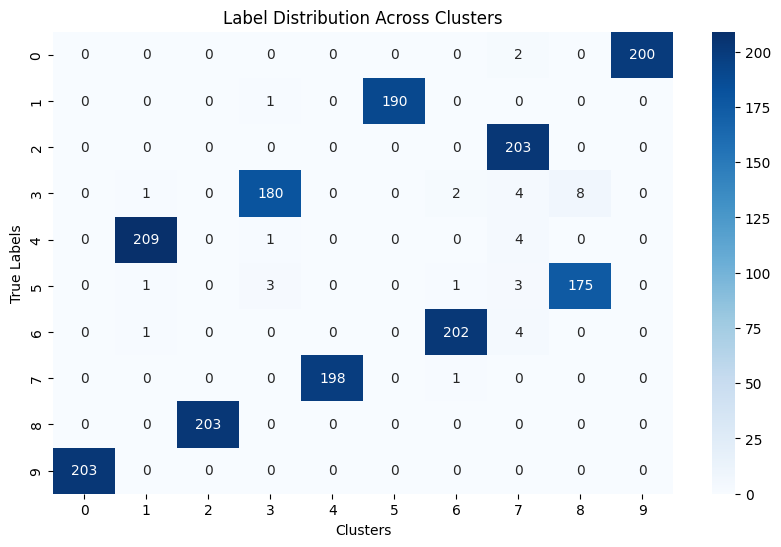

In [15]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [16]:


def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [35]:
X_test, y_test = getDataset(train=False, sample_size=10000)

Files already downloaded and verified


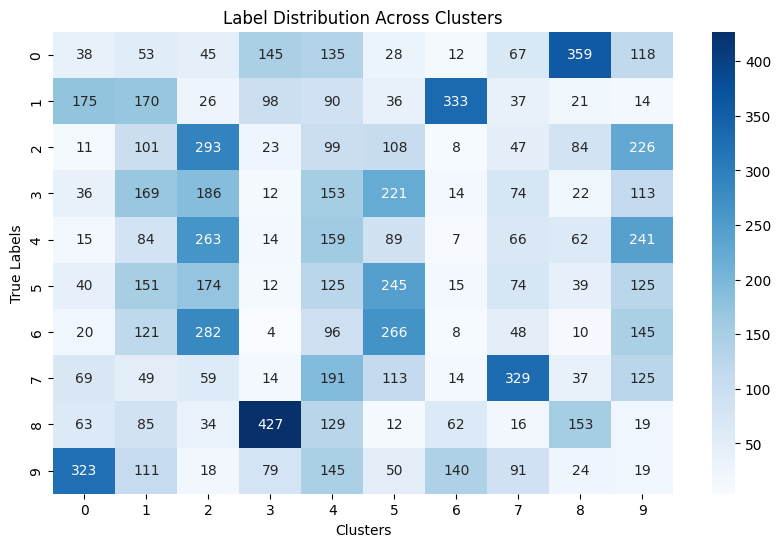

In [37]:

easyHeatmap(model(X_test).detach().numpy() , y_test)

In [34]:
res = (model(X_test).detach().numpy() > 0.5).astype(int)
mean_average_precision( res , y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\thors\AppData\Local\Temp\ipykernel_10032\1685813318.py:15: RuntimeWarning: Mean of empty slice.
  ap = precision.mean()
c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\thors\AppData\Local\Temp\ipykernel_10032\1685813318.py:15: RuntimeWarning: Mean of empty slice.
  ap = precision.mean()
c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\thors\AppData\Local\Temp\ipykernel_10032\1685813318.py:15: RuntimeWarning: Mean of empty slice.
  ap = precision.mean()
c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.t

nan

In [29]:
res

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0]])

In [30]:
y_test

[3,
 8,
 8,
 0,
 6,
 6,
 1,
 6,
 3,
 1,
 0,
 9,
 5,
 7,
 9,
 8,
 5,
 7,
 8,
 6,
 7,
 0,
 4,
 9,
 5,
 2,
 4,
 0,
 9,
 6,
 6,
 5,
 4,
 5,
 9,
 2,
 4,
 1,
 9,
 5,
 4,
 6,
 5,
 6,
 0,
 9,
 3,
 9,
 7,
 6,
 9,
 8,
 0,
 3,
 8,
 8,
 7,
 7,
 4,
 6,
 7,
 3,
 6,
 3,
 6,
 2,
 1,
 2,
 3,
 7,
 2,
 6,
 8,
 8,
 0,
 2,
 9,
 3,
 3,
 8,
 8,
 1,
 1,
 7,
 2,
 5,
 2,
 7,
 8,
 9,
 0,
 3,
 8,
 6,
 4,
 6,
 6,
 0,
 0,
 7,
 4,
 5,
 6,
 3,
 1,
 1,
 3,
 6,
 8,
 7,
 4,
 0,
 6,
 2,
 1,
 3,
 0,
 4,
 2,
 7,
 8,
 3,
 1,
 2,
 8,
 0,
 8,
 3,
 5,
 2,
 4,
 1,
 8,
 9,
 1,
 2,
 9,
 7,
 2,
 9,
 6,
 5,
 6,
 3,
 8,
 7,
 6,
 2,
 5,
 2,
 8,
 9,
 6,
 0,
 0,
 5,
 2,
 9,
 5,
 4,
 2,
 1,
 6,
 6,
 8,
 4,
 8,
 4,
 5,
 0,
 9,
 9,
 9,
 8,
 9,
 9,
 3,
 7,
 5,
 0,
 0,
 5,
 2,
 2,
 3,
 8,
 6,
 3,
 4,
 0,
 5,
 8,
 0,
 1,
 7,
 2,
 8,
 8,
 7,
 8,
 5,
 1,
 8,
 7,
 1,
 3,
 0,
 5,
 7,
 9,
 7,
 4,
 5,
 9,
 8,
 0,
 7,
 9,
 8,
 2,
 7,
 6,
 9,
 4,
 3,
 9,
 6,
 4,
 7,
 6,
 5,
 1,
 5,
 8,
 8,
 0,
 4,
 0,
 5,
 5,
 1,
 1,
 8,
 9,
 0,
 3,
 1,
 9,
 2,
 2,


In [2]:
from torchvision import models
pretrained_model = models.vgg16(pretrained=True)

c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
pretrained_model

In [6]:
X, y = getDataset(sample_size=5)

Files already downloaded and verified


In [9]:
pretrained_model(X).shape

torch.Size([5, 1000])

In [10]:
pretrained_model.classifier = torch.nn.Identity()
pretrained_model(X).shape

torch.Size([5, 25088])

In [13]:

test_model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(25088,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

In [17]:
test_model(pretrained_model(X))

tensor([[0.4245, 0.5084, 0.5166, 0.5006, 0.5573, 0.5283, 0.5438, 0.4899, 0.5422,
         0.5346, 0.5107, 0.5003, 0.4894, 0.4449, 0.4833, 0.4821, 0.4330, 0.5755,
         0.4581, 0.4496, 0.5068, 0.4802, 0.4785, 0.5069, 0.4366, 0.4889, 0.5582,
         0.4705, 0.5439, 0.4617, 0.4815, 0.5624],
        [0.4790, 0.5212, 0.5364, 0.4721, 0.5454, 0.4723, 0.5303, 0.4412, 0.5292,
         0.5141, 0.5024, 0.5445, 0.4610, 0.5115, 0.5545, 0.5070, 0.4624, 0.5480,
         0.4963, 0.4771, 0.4903, 0.5049, 0.4801, 0.5370, 0.4331, 0.4603, 0.5738,
         0.5249, 0.5557, 0.5064, 0.4687, 0.4984],
        [0.5148, 0.4807, 0.4848, 0.5033, 0.5407, 0.4567, 0.5414, 0.4699, 0.5238,
         0.4758, 0.5077, 0.5224, 0.4736, 0.5086, 0.5061, 0.4885, 0.4491, 0.5221,
         0.5049, 0.4639, 0.5175, 0.4577, 0.5328, 0.5011, 0.5068, 0.4948, 0.5258,
         0.4710, 0.5478, 0.5025, 0.4869, 0.5024],
        [0.4711, 0.4934, 0.5344, 0.5265, 0.5204, 0.4700, 0.5473, 0.5002, 0.5237,
         0.4721, 0.4941, 0.5244, 0.5214,